In [1]:
import jcopdl, luwiji

In [2]:
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.1.2')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [8]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [9]:
# Kalau manual tanpa block

# nn.Conv2d(3, 8, 1, 1)
# nn.ReLU(),
# nn.MaxPool2d(2, 2)

In [10]:
from jcopdl.layers import conv_block, linear_block

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x        

In [12]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [13]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6928 | Test_cost  = 0.6883 | Train_score = 0.4980 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.6859 | Test_cost  = 0.6674 | Train_score = 0.5610 | Test_score = 0.6525 |




Epoch     3
Train_cost  = 0.6412 | Test_cost  = 0.5717 | Train_score = 0.7370 | Test_score = 0.8125 |




Epoch     4
Train_cost  = 0.5305 | Test_cost  = 0.4249 | Train_score = 0.7650 | Test_score = 0.8375 |




Epoch     5
Train_cost  = 0.4459 | Test_cost  = 0.3884 | Train_score = 0.7970 | Test_score = 0.8350 |
==> EarlyStop patience =  1 | Best test_score: 0.8375




Epoch     6
Train_cost  = 0.4038 | Test_cost  = 0.4174 | Train_score = 0.8010 | Test_score = 0.7875 |
==> EarlyStop patience =  2 | Best test_score: 0.8375




Epoch     7
Train_cost  = 0.3827 | Test_cost  = 0.3427 | Train_score = 0.8330 | Test_score = 0.8675 |




Epoch     8
Train_cost  = 0.3811 | Test_cost  = 0.4417 | Train_score = 0.8160 | Test_score = 0.7900 |
==> EarlyStop patience =  1 | Best test_score: 0.8675




Epoch     9
Train_cost  = 0.3759 | Test_cost  = 0.3668 | Train_score = 0.8170 | Test_score = 0.8400 |
==> EarlyStop patience =  2 | Best test_score: 0.8675




Epoch    10
Train_cost  = 0.3929 | Test_cost  = 0.3391 | Train_score = 0.8180 | Test_score = 0.8625 |
==> EarlyStop patience =  3 | Best test_score: 0.8675




Epoch    11
Train_cost  = 0.3461 | Test_cost  = 0.3293 | Train_score = 0.8470 | Test_score = 0.8750 |




Epoch    12
Train_cost  = 0.3395 | Test_cost  = 0.3535 | Train_score = 0.8410 | Test_score = 0.8375 |
==> EarlyStop patience =  1 | Best test_score: 0.8750




Epoch    13
Train_cost  = 0.3277 | Test_cost  = 0.3071 | Train_score = 0.8510 | Test_score = 0.8700 |
==> EarlyStop patience =  2 | Best test_score: 0.8750




Epoch    14
Train_cost  = 0.3207 | Test_cost  = 0.3265 | Train_score = 0.8610 | Test_score = 0.8625 |
==> EarlyStop patience =  3 | Best test_score: 0.8750




Epoch    15
Train_cost  = 0.3175 | Test_cost  = 0.3631 | Train_score = 0.8590 | Test_score = 0.8325 |
==> EarlyStop patience =  4 | Best test_score: 0.8750




Epoch    16
Train_cost  = 0.3213 | Test_cost  = 0.2903 | Train_score = 0.8620 | Test_score = 0.8800 |




Epoch    17
Train_cost  = 0.3005 | Test_cost  = 0.3585 | Train_score = 0.8690 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8800




Epoch    18
Train_cost  = 0.2958 | Test_cost  = 0.2728 | Train_score = 0.8870 | Test_score = 0.8875 |




Epoch    19
Train_cost  = 0.2922 | Test_cost  = 0.2777 | Train_score = 0.8810 | Test_score = 0.8925 |




Epoch    20
Train_cost  = 0.2992 | Test_cost  = 0.2877 | Train_score = 0.8810 | Test_score = 0.8850 |


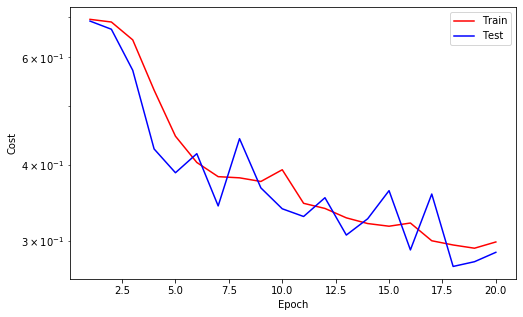

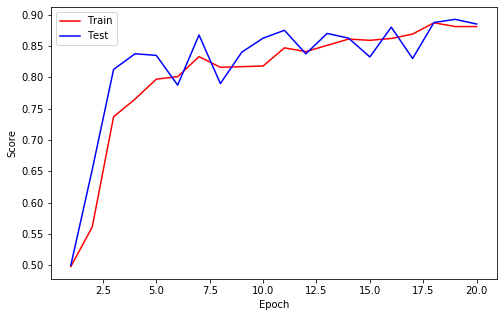

==> EarlyStop patience =  1 | Best test_score: 0.8925




Epoch    21
Train_cost  = 0.3141 | Test_cost  = 0.2726 | Train_score = 0.8680 | Test_score = 0.8875 |
==> EarlyStop patience =  2 | Best test_score: 0.8925




Epoch    22
Train_cost  = 0.2902 | Test_cost  = 0.2615 | Train_score = 0.8840 | Test_score = 0.8875 |
==> EarlyStop patience =  3 | Best test_score: 0.8925




Epoch    23
Train_cost  = 0.2797 | Test_cost  = 0.2549 | Train_score = 0.8880 | Test_score = 0.8900 |
==> EarlyStop patience =  4 | Best test_score: 0.8925




Epoch    24
Train_cost  = 0.2614 | Test_cost  = 0.2482 | Train_score = 0.8940 | Test_score = 0.8925 |
==> EarlyStop patience =  5 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 24 | Best test_score: 0.8925
==> Best model is saved at model


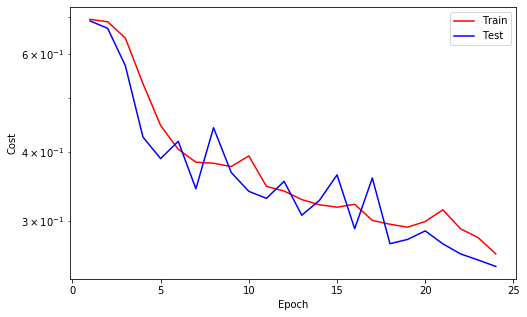

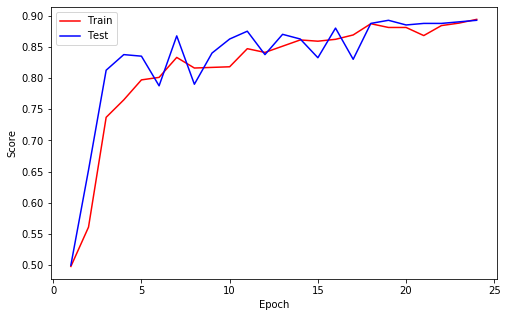

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [16]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [17]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')

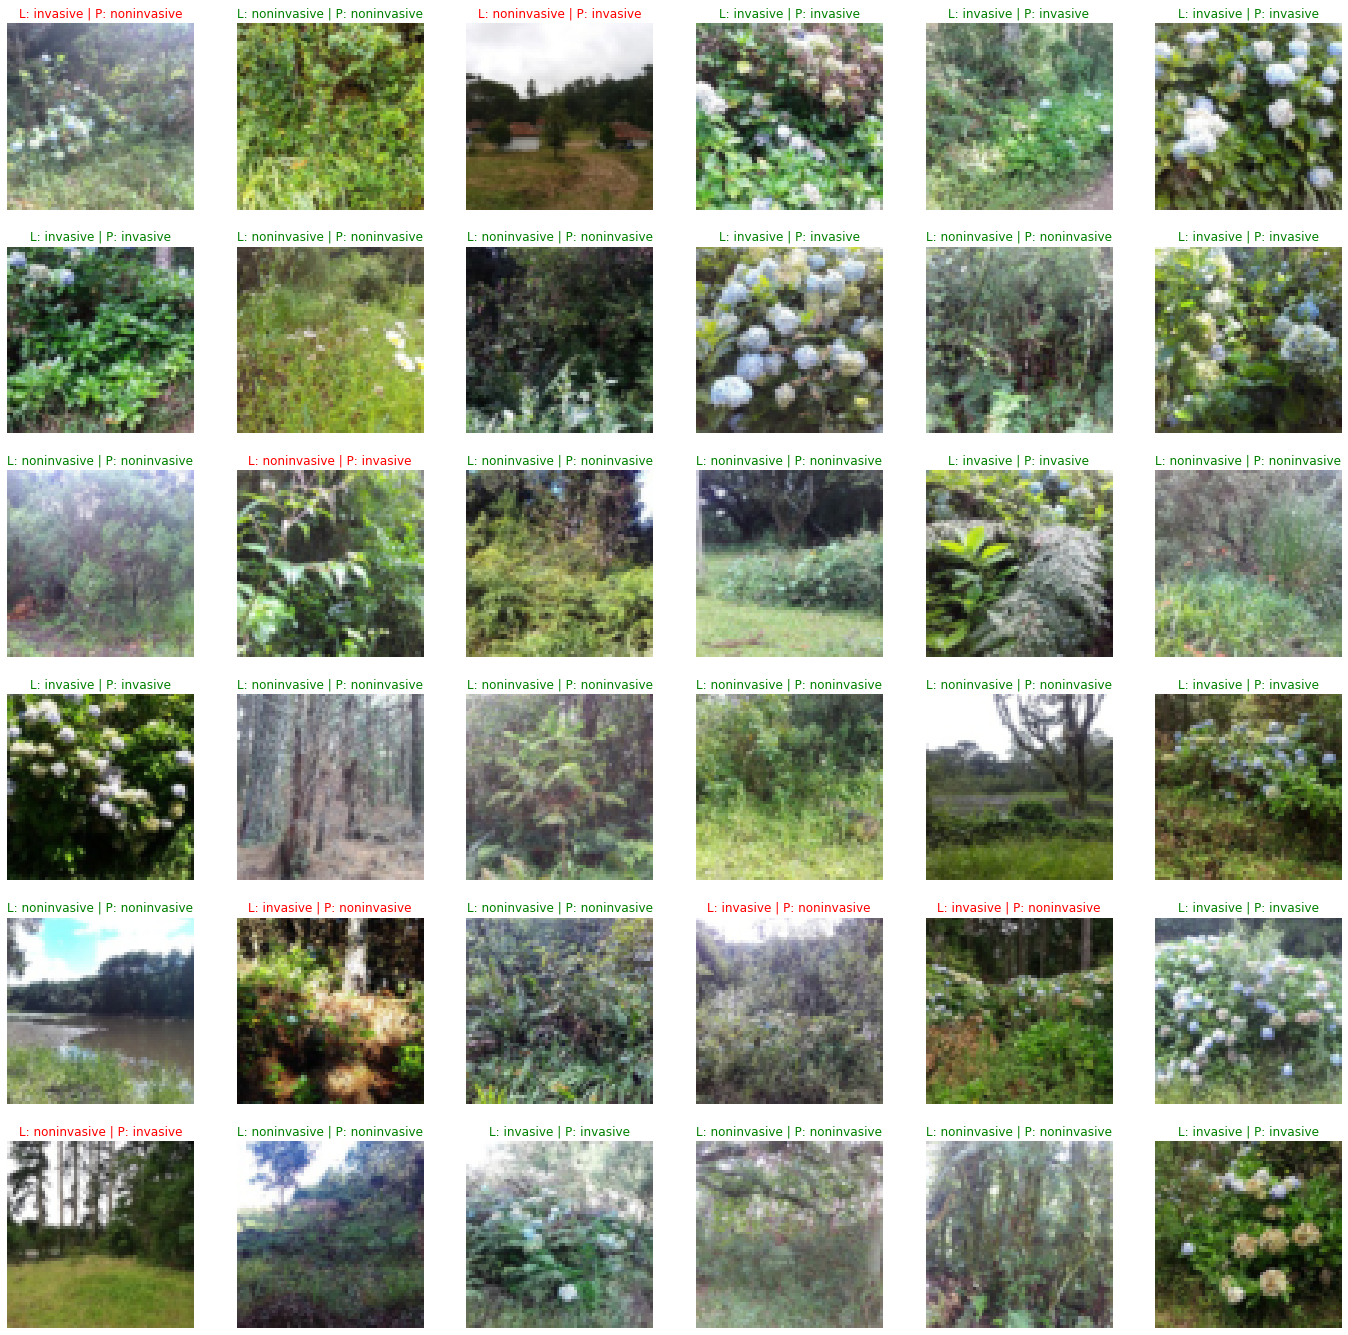

In [18]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color":'r'} if label != pred else{"color":'g'}
    label, pred =label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');